In [46]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [47]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import VotingRegressor, StackingRegressor

# suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [58]:
vaccine_data = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240111.csv')
death_data = pd.read_csv('data/deaths_with_abbs.csv')
data = pd.read_csv('data/covid_deaths2.csv')
death_data

,Data as of,Start Date,End Date,Group,Year,Month,MMWR Week,Week Ending Date,State,COVID-19 Deaths,Total Deaths,Percent of Expected Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote,Location
0,01/11/2024,12/29/2019,01/04/2020,By Week,2019/2020,NaN,1.0,01/04/2020,United States,0.0,60170.0,98.0,4111.0,0.0,434.0,4545.0,NaN,NaN
1,01/11/2024,01/05/2020,01/11/2020,By Week,2020,NaN,2.0,01/11/2020,United States,1.0,60734.0,97.0,4153.0,1.0,475.0,4628.0,NaN,NaN
2,01/11/2024,01/12/2020,01/18/2020,By Week,2020,NaN,3.0,01/18/2020,United States,2.0,59362.0,98.0,4066.0,2.0,468.0,4534.0,NaN,NaN
3,01/11/2024,01/19/2020,01/25/2020,By Week,2020,NaN,4.0,01/25/2020,United States,3.0,59162.0,99.0,3915.0,0.0,500.0,4418.0,NaN,NaN
4,01/11/2024,01/26/2020,02/01/2020,By Week,2020,NaN,5.0,02/01/2020,United States,0.0,58834.0,99.0,3818.0,0.0,481.0,4299.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14305,01/11/2024,01/01/2020,01/06/2024,By Total,NaN,NaN,NaN,NaN,Washington,15510.0,265746.0,NaN,20905.0,9023.0,590.0,27950.0,NaN,WA
14306,01/11/2024,01/01/2020,01/06/2024,By Total,NaN,NaN,NaN,NaN,West Virginia,8548.0,105264.0,NaN,11252.0,4361.0,214.0,15640.0,NaN,WV
14307,01/11/2024,01/01/2020,01/06/2024,By Total,NaN,NaN,NaN,NaN,Wisconsin,17500.0,240385.0,NaN,15338.0,6176.0,449.0,27075.0,NaN,WI
14308,01/11/2024,01/01/2020,01/06/2024,By Total,NaN,NaN,NaN,NaN,Wyoming,1903.0,22099.0,NaN,1948.0,988.0,41.0,2902.0,NaN,WY


In [38]:
result_data = death_data.groupby(['End Date', 'MMWR Week'], as_index=False)['COVID-19 Deaths'].sum()

# Print or inspect the resulting DataFrame
print(result_data)

       End Date  MMWR Week  COVID-19 Deaths
0    01/01/2022       52.0          23423.0
1    01/02/2021       53.0          49851.0
2    01/04/2020        1.0              0.0
3    01/06/2024        1.0           1735.0
4    01/07/2023        1.0           7751.0
..          ...        ...              ...
205  12/24/2022       51.0           6646.0
206  12/25/2021       51.0          20945.0
207  12/26/2020       52.0          46881.0
208  12/30/2023       52.0           2801.0
209  12/31/2022       52.0           7326.0

[210 rows x 3 columns]


In [11]:
# Remove constant features
constant_features = data.columns[data.nunique() == 1]
print(constant_features)

Index([], dtype='object')


In [12]:
#remove redundant features
corr_matrix = data.corr().abs()
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
correlated_columns = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.25)]

In [13]:
correlated_columns

['Unnamed: 0',
 'MMWR_week',
 'Distributed',
 'Distributed_Janssen',
 'Distributed_Moderna',
 'Distributed_Pfizer',
 'Distributed_Novavax',
 'Distributed_Unk_Manuf',
 'Dist_Per_100K',
 'Distributed_Per_100k_5Plus',
 'Distributed_Per_100k_12Plus',
 'Distributed_Per_100k_18Plus',
 'Distributed_Per_100k_65Plus',
 'Administered',
 'Administered_5Plus',
 'Administered_12Plus',
 'Administered_18Plus',
 'Administered_65Plus',
 'Administered_Janssen',
 'Administered_Moderna',
 'Administered_Pfizer',
 'Administered_Novavax',
 'Administered_Unk_Manuf',
 'Admin_Per_100K',
 'Admin_Per_100k_5Plus',
 'Admin_Per_100k_12Plus',
 'Admin_Per_100k_18Plus',
 'Admin_Per_100k_65Plus',
 'Recip_Administered',
 'Administered_Dose1_Recip',
 'Administered_Dose1_Pop_Pct',
 'Administered_Dose1_Recip_5Plus',
 'Administered_Dose1_Recip_5PlusPop_Pct',
 'Administered_Dose1_Recip_12Plus',
 'Administered_Dose1_Recip_12PlusPop_Pct',
 'Administered_Dose1_Recip_18Plus',
 'Administered_Dose1_Recip_18PlusPop_Pct',
 'Administe

In [14]:
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                     Unnamed: 0  MMWR_week  Distributed  Distributed_Janssen  \
Unnamed: 0             1.000000   0.094259     0.417619             0.360805   
MMWR_week              0.094259   1.000000     0.040339             0.069973   
Distributed            0.417619   0.040339     1.000000             0.977400   
Distributed_Janssen    0.360805   0.069973     0.977400             1.000000   
Distributed_Moderna    0.412786   0.060121     0.995835             0.985062   
...                         ...        ...          ...                  ...   
region_y_West          0.012697   0.018105     0.009709             0.014864   
season_fall            0.111601   0.582533     0.024185             0.031559   
season_spring          0.052176   0.342632     0.064048             0.052631   
season_summer          0.006252   0.157788     0.024319             0.061855   
season_winter          0.142062   0.288819     0.105031             0.131593   

                   

In [15]:
correlation_matrix = data.corr()['covid19_deaths']
print("Correlation Matrix with Target Variable:")
print(correlation_matrix)

Correlation Matrix with Target Variable:
Unnamed: 0             0.168967
MMWR_week             -0.045031
Distributed            0.209108
Distributed_Janssen    0.227577
Distributed_Moderna    0.198658
                         ...   
region_y_West         -0.028365
season_fall            0.026296
season_spring         -0.210485
season_summer         -0.101769
season_winter          0.273261
Name: covid19_deaths, Length: 120, dtype: float64


<AxesSubplot:>

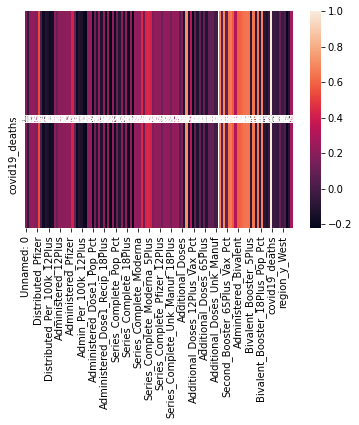

In [16]:
correlation_df = pd.DataFrame(correlation_matrix)
sns.heatmap(correlation_df.transpose(), annot=True)

# Lag + Rolling Mean - edit w/ new data 

In [55]:
import pandas as pd

# Assuming 'result_data' contains your dataset with a column named 'Covid19_deaths'
# Sort the DataFrame by 'End Date' if it's not already sorted
data.sort_values(by='Date', inplace=True)

# Lag features
num_lags = 3  # Number of lag features
for i in range(1, num_lags + 1):
    data[f'covid19_deaths_lag_{i}'] = data['covid19_deaths'].shift(i)

# Rolling statistics
window_size = 7  # Rolling window size
data['rolling_mean'] = data['covid19_deaths'].rolling(window=window_size).mean()
data['rolling_std'] = data['covid19_deaths'].rolling(window=window_size).std()

# Print the updated DataFrame to verify the changes
print(data)

            Unnamed: 0  MMWR_week Location  Distributed  Distributed_Janssen  \
Date                                                                           
2020-12-14       31627         51       MA         5850                    0   
2020-12-14       31625         51       PR        16575                    0   
2020-12-14       31624         51       AK         4875                    0   
2020-12-14       31623         51       IN         1950                    0   
2020-12-14       31622         51       DE          975                    0   
...                ...        ...      ...          ...                  ...   
2023-05-10          19         19       RI      3531485                90600   
2023-05-10          22         19       KY     12200975               395600   
2023-05-10          30         19       MO     15654225               441000   
2023-05-10          29         19       FL     61526685              2477700   
2023-05-10           2         19       

# Seasonality

In [57]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'data' contains your dataset with a DateTime index
# If not, set the index to your DateTime column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['covid19_deaths'], model='additive')

# Plot the decomposition
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(data['covid19_deaths'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show() 

KeyError: 'Date'

In [22]:
# Find the non-binary categorical columns
cat_cols = []
for col in data.columns:
    if data[col].dtype == 'object' and len(data[col].unique()) > 2:
        cat_cols.append(col)
print("Non-binary categorical columns:", cat_cols)

# Create binary columns from the categorical columns
data = pd.get_dummies(data, columns=cat_cols)

# Print the resulting dataframe
print(data.head())

Non-binary categorical columns: ['Date', 'Location']
   Unnamed: 0  MMWR_week  Distributed  Distributed_Janssen  \
0           2         19     28727475               869100   
1           4         19     17769135               501900   
2           5         19     42895735              1569200   
3           8         19     16474175               457200   
4          10         19     80813315              2667600   

   Distributed_Moderna  Distributed_Pfizer  Distributed_Novavax  \
0              9763000            14773655              43400.0   
1              5402640             9029715              43600.0   
2             13941120            21178525              87400.0   
3              5144600             8183105              22900.0   
4             25478340            43584365             119500.0   

   Distributed_Unk_Manuf  Dist_Per_100K  Distributed_Per_100k_5Plus  ...  \
0                      0         270569                    288404.0  ...   
1                  

In [29]:
#split the target value and the features
y= data['covid19_deaths']
X= data.drop(['covid19_deaths','Unnamed: 0',], axis=1) 

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=45)

#scale the features
scaler = StandardScaler()

scaler.fit(X_train)
scaler.fit(X_test)
scaler_train = scaler.transform(X_train)
scaler_test = scaler.transform(X_test)

def initialize(dim):
    weights = np.full((dim,),0.01)
    bias = 0.0
    return weights, bias 

def predict(model_parameters, X_test):
    weights = model_parameters['bias']
    bias = model_parameters['bias']
    
    y_pred = np.dot(X_test, weights) + bias 
    
    return y_pred

ValueError: could not convert string to float: '2021-02-07'